In [ ]:
from google.colab import drive
drive.mount('/content/drive')

!pip install gradio jinja2

import pandas as pd
import tensorflow as tf
import gradio as gr

df = pd.read_csv("drive/MyDrive/CommentAnalyzer/train.csv")
x = df['comment_text']
y = df[df.columns[2:]].values

vectorizer = TextVectorization(
    max_tokens=200000, output_sequence_length = 1800, output_mode='int'
)
vectorizer.adapt(x.values)

model = tf.keras.models.load_model('drive/MyDrive/CommentAnalyzer/analyzer.h5')

def score_comment(comment):
  vectorized_comment = vectorizer([comment])
  results = model.predict(vectorized_comment)

  text = ''
  for idx, col in enumerate(df.columns[2:-1]):
    text += '{}: {}\n'.format(col, results[0][idx]>0.5)

  return text

interface = gr.Interface(fn=score_comment, inputs = gr.inputs.Textbox(lines=2, placeholder='Comment to score'), outputs='text')
interface.launch(share=True, debug=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Install Dependencies and Bring in Data

In [ ]:
#pip install tensorflow tensorflow-gpu pandas matplotlib sklearn

In [ ]:
import pandas as pd
import tensorflow as tf
import numpy as np

In [ ]:
df = pd.read_csv("drive/MyDrive/CommentAnalyzer/train.csv")
df.head()

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


# Preprocess

In [ ]:
from tensorflow.keras.layers import TextVectorization

In [ ]:
x = df['comment_text']
y = df[df.columns[2:]].values

In [ ]:
MAX_FEATURES = 200000 # number of words in the vocab

In [ ]:
vectorizer = TextVectorization(
    max_tokens=MAX_FEATURES, output_sequence_length = 1800, output_mode='int'
)
vectorizer.adapt(x.values)

In [ ]:
vectorizer.adapt(x.values)

In [ ]:
vectorized_text = vectorizer(x.values)

In [ ]:
#MCSHBAP - map, cache, shuffle, batch, prefetch from_tensor_slices, list_file
dataset = tf.data.Dataset.from_tensor_slices((vectorized_text, y))
dataset = dataset.cache()
dataset = dataset.shuffle(160000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8) # helps bottlenecks

In [ ]:
batch_x, batch_y = dataset.as_numpy_iterator().next()

In [ ]:
train = dataset.take(int(len(dataset)*.7))
val = dataset.skip(int(len(dataset)*.7)).take(int(len(dataset)*.2))
test = dataset.skip(int(len(dataset)*.9)).take(int(len(dataset)*.1))

In [ ]:
train_generator = train.as_numpy_iterator()

In [ ]:
train_generator.next()

(array([[    8,     9,  4064, ...,     0,     0,     0],
        [31116,   729,   126, ...,     0,     0,     0],
        [  165,  1073,    42, ...,     0,     0,     0],
        ...,
        [  239,   485,   131, ...,     0,     0,     0],
        [  321,  1796,     4, ...,     0,     0,     0],
        [49671,    30,  1905, ...,     0,     0,     0]]),
 array([[0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0]]))

# Create Sequential Model

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense, Embedding

In [ ]:
model = Sequential()
# Create the embedding layer
model.add(Embedding(MAX_FEATURES+1, 32))
# Birectional LSTM layer
model.add(Bidirectional(LSTM(32, activation='tanh')))
# Feature extractor Fully connected layers
model.add(Dense(128, activation='relu'))
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
# final layer
model.add(Dense(6, activation='sigmoid'))

In [ ]:
model.compile(loss='BinaryCrossentropy', optimizer='Adam')

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, None, 32)          6400032   
                                                                 
 bidirectional (Bidirectiona  (None, 64)               16640     
 l)                                                              
                                                                 
 dense (Dense)               (None, 128)               8320      
                                                                 
 dense_1 (Dense)             (None, 256)               33024     
                                                                 
 dense_2 (Dense)             (None, 128)               32896     
                                                                 
 dense_3 (Dense)             (None, 6)                 774       
                                                        

In [ ]:
history = model.fit(train, epochs=10, validation_data=val)

Epoch 1/10
6981/6981 [==============================] - 642s 92ms/step - loss: 0.0457 - val_loss: 0.0384
Epoch 2/10
6981/6981 [==============================] - 637s 91ms/step - loss: 0.0401 - val_loss: 0.0377
Epoch 3/10
6981/6981 [==============================] - 650s 93ms/step - loss: 0.0354 - val_loss: 0.0318
Epoch 4/10
6981/6981 [==============================] - 699s 100ms/step - loss: 0.0314 - val_loss: 0.0285
Epoch 5/10
6981/6981 [==============================] - 663s 95ms/step - loss: 0.0283 - val_loss: 0.0231
Epoch 6/10
6981/6981 [==============================] - 622s 89ms/step - loss: 0.0250 - val_loss: 0.0211
Epoch 7/10
6981/6981 [==============================] - 623s 89ms/step - loss: 0.0221 - val_loss: 0.0196
Epoch 8/10
6981/6981 [==============================] - 617s 88ms/step - loss: 0.0198 - val_loss: 0.0163
Epoch 9/10
6981/6981 [==============================] - 617s 88ms/step - loss: 0.0175 - val_loss: 0.0150
Epoch 10/10
6981/6981 [==============================]

In [ ]:
history.history

{'loss': [0.045731786638498306,
  0.04006573185324669,
  0.03535107150673866,
  0.03138549253344536,
  0.028339451178908348,
  0.024998445063829422,
  0.022118782624602318,
  0.01982141099870205,
  0.017514266073703766,
  0.016021721065044403],
 'val_loss': [0.038352109491825104,
  0.03774768486618996,
  0.031795650720596313,
  0.028480587527155876,
  0.023112939670681953,
  0.02106110006570816,
  0.019639715552330017,
  0.016324734315276146,
  0.014990003779530525,
  0.012674244120717049]}

In [ ]:
import matplotlib.pyplot as plt

<Figure size 800x500 with 0 Axes>

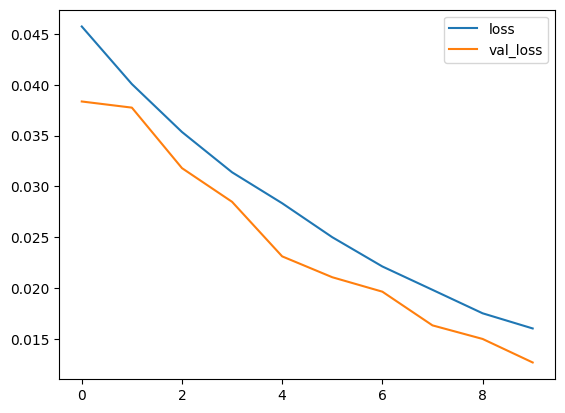

In [ ]:
plt.figure(figsize=(8, 5))
pd.DataFrame(history.history).plot()
plt.show()

# Make Predictions

In [ ]:
input_text = vectorizer('You freaking suck! I am going to hurt you.')

In [ ]:
batch = test.as_numpy_iterator().next()

In [ ]:
batch_x, batch_y = test.as_numpy_iterator().next()

In [ ]:
res = model.predict(batch_x)

1/1 [==============================] - 0s 62ms/step


In [ ]:
model.predict(batch_x)

1/1 [==============================] - 0s 78ms/step


array([[5.73536545e-06, 3.27489387e-18, 2.02815528e-07, 1.95902867e-08,
        4.52996929e-08, 4.64468641e-09],
       [1.35041228e-10, 1.12373837e-30, 9.38796458e-13, 5.31157082e-15,
        5.85548252e-14, 8.67238918e-16],
       [9.54160273e-01, 9.60577017e-05, 5.21922205e-03, 6.96395582e-04,
        1.15613751e-02, 2.36044545e-03],
       [1.18162529e-08, 1.47928570e-23, 1.88003266e-10, 5.52372330e-13,
        2.02268514e-11, 1.79588245e-12],
       [9.84441042e-01, 7.26081225e-06, 1.36585371e-03, 2.65677572e-05,
        1.07582947e-02, 3.49471229e-04],
       [1.36822758e-12, 1.63177930e-35, 2.76383886e-15, 1.88039699e-19,
        1.38294368e-16, 2.66399203e-19],
       [1.44090145e-05, 4.18401938e-19, 3.65380316e-07, 1.22128458e-08,
        1.54186267e-07, 3.29123995e-09],
       [4.50011721e-04, 2.64063863e-13, 4.20966026e-05, 3.74896103e-06,
        1.86591114e-05, 1.11050315e-06],
       [5.44692099e-01, 1.02026677e-02, 3.87215875e-02, 3.98394763e-02,
        3.12874705e-01, 

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy

In [ ]:
pre = Precision()
re = Recall()
acc = CategoricalAccuracy()

In [ ]:
for batch in test.as_numpy_iterator():
  # Unpack the batch
  x_true, y_true = batch
  # Make a prediction
  yhat = model.predict(x_true)

  # Flatten the predictions
  y_true = y_true.flatten()
  yhat = yhat.flatten()

  pre.update_state(y_true, yhat)
  re.update_state(y_true, yhat)
  acc.update_state(y_true, yhat)

1/1 [==============================] - 0s 50ms/step


In [ ]:
print(f'Precision : {pre.result().numpy()}, Recall:{re.result().numpy()}, Accuracy:{acc.result().numpy()}')

Precision : 0.9339649081230164, Recall:0.9290465712547302, Accuracy:0.4563691020011902


# Test and Gradio

In [ ]:
!pip install gradio jinja2

In [ ]:
import gradio as gr
import tensorflow as tf

In [ ]:
model.save('drive/MyDrive/CommentAnalyzer/analyzer.h5')

In [ ]:
model = tf.keras.models.load_model('drive/MyDrive/CommentAnalyzer/analyzer.h5')

In [ ]:
input_str = vectorizer('hey i freaken hate you! I am coming for you. I\'m going to hurt you!')

In [ ]:
res = model.predict(np.expand_dims(input_str, 0))

1/1 [==============================] - 0s 61ms/step


In [ ]:
df.columns[2:]

Index(['toxic', 'severe_toxic', 'obscene', 'threat', 'insult',
       'identity_hate'],
      dtype='object')

In [ ]:
res

array([[0.75859326, 0.0065019 , 0.16148281, 0.00553114, 0.28620705,
        0.01367605]], dtype=float32)

In [ ]:
interface = gr.Interface(fn=score_comment, inputs = gr.inputs.Textbox(lines=2, placeholder='Comment to score'), outputs='text')
interface.launch(share=True, debug=True)

/usr/local/lib/python3.10/dist-packages/gradio/inputs.py:27: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.10/dist-packages/gradio/deprecation.py:40: UserWarning: `numeric` parameter is deprecated, and it has no effect
  warnings.warn(value)
